#1. Initialize Environment for MySQL

In [1]:
# Installation and initial setup
!apt-get update
!apt-get install -y mysql-server
!pip install mysql-connector-python==8.0.33

# Start MySQL service
!service mysql start

# Configure MySQL root access
!sudo mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY ''"
!sudo service mysql restart

print("Initial setup complete. Please Restart runtime...")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 2s (184 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [2]:
# Configure MySQL root access
!sudo mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY ''"

# Verify installation
import mysql.connector
conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password=""
    )
print("MySQL setup successful!")
conn.close()

    # Ready to proceed

MySQL setup successful!


#2. Start Whale Dive Analysis System DB

In [3]:
import mysql.connector
import os

def setup_database():
    try:
        # Connect to MySQL
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password=""
        )
        cursor = conn.cursor()

        # Drop and recreate the database
        cursor.execute("DROP DATABASE IF EXISTS WDAS_TEST;")
        cursor.execute("CREATE DATABASE WDAS_TEST;")
        cursor.execute("USE WDAS_TEST;")

        # USERS Table
        cursor.execute("""
        CREATE TABLE USERS (
            user_id INT AUTO_INCREMENT PRIMARY KEY,
            username VARCHAR(50) NOT NULL UNIQUE,
            password_hash VARCHAR(255) NOT NULL,
            role ENUM('Admin', 'Researcher', 'Viewer') DEFAULT 'Viewer',
            creation_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """)

        # DATASET_DETAILS Table
        cursor.execute("""
        CREATE TABLE DATASET_DETAILS (
            dataset_id INT AUTO_INCREMENT PRIMARY KEY,
            dataset_name VARCHAR(255) NOT NULL,
            dataset_date DATE NOT NULL,
            researcher VARCHAR(100),
            notes TEXT,
            created_by INT,
            FOREIGN KEY (created_by) REFERENCES USERS(user_id) ON DELETE SET NULL
        );
        """)

        # WHALES Table
        cursor.execute("""
        CREATE TABLE WHALES (
            whale_id INT AUTO_INCREMENT PRIMARY KEY,
            tag_id VARCHAR(50) UNIQUE NOT NULL,
            species VARCHAR(50),
            age INT,
            sex ENUM('M', 'F', 'Unknown'),
            notes TEXT
        );
        """)

        # DATASETS Table
        cursor.execute("""
        CREATE TABLE DATASETS (
            dataset_id INT NOT NULL,
            sample_ref BIGINT NOT NULL,
            framerate INT NOT NULL,
            pressure FLOAT,
            tempr FLOAT,
            M1 FLOAT,
            M2 FLOAT,
            M3 FLOAT,
            A1 FLOAT,
            A2 FLOAT,
            A3 FLOAT,
            Aw1 FLOAT,
            Aw2 FLOAT,
            Aw3 FLOAT,
            Mw1 FLOAT,
            Mw2 FLOAT,
            Mw3 FLOAT,
            pitch FLOAT,
            roll FLOAT,
            head FLOAT,
            PRIMARY KEY (dataset_id, sample_ref),
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            INDEX idx_sample_ref (sample_ref)
        );
        """)

        # CLASS_SUBCLASS_MAP Table
        cursor.execute("""
        CREATE TABLE CLASS_SUBCLASS_MAP (
            id INT AUTO_INCREMENT PRIMARY KEY,
            class VARCHAR(50) NOT NULL,
            subclass VARCHAR(255) NOT NULL,
            UNIQUE(class, subclass)
        );
        """)

        # ANNOTATIONS Table
        cursor.execute("""
        CREATE TABLE ANNOTATIONS (
            annotation_id INT AUTO_INCREMENT PRIMARY KEY,
            dataset_id INT NOT NULL,
            whale_id INT NOT NULL,
            start_sample BIGINT NOT NULL,
            end_sample BIGINT NOT NULL,
            class VARCHAR(50) NOT NULL,
            subclass VARCHAR(255) NOT NULL,
            confidence_score FLOAT,
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            FOREIGN KEY (whale_id) REFERENCES WHALES(whale_id) ON DELETE CASCADE,
            FOREIGN KEY (class, subclass) REFERENCES CLASS_SUBCLASS_MAP(class, subclass),
            CHECK (start_sample <= end_sample),
            INDEX idx_class (class),
            INDEX idx_subclass (subclass)
        );
        """)

        # ANNOTATION_HISTORY Table
        cursor.execute("""
        CREATE TABLE ANNOTATION_HISTORY (
            history_id INT AUTO_INCREMENT PRIMARY KEY,
            annotation_id INT NOT NULL,
            previous_class VARCHAR(255),
            updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            updated_by VARCHAR(50),
            reason_for_change TEXT,
            FOREIGN KEY (annotation_id) REFERENCES ANNOTATIONS(annotation_id) ON DELETE CASCADE
        );
        """)

        # LOGS Table
        cursor.execute("""
        CREATE TABLE LOGS (
            log_id INT AUTO_INCREMENT PRIMARY KEY,
            log_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            table_name VARCHAR(50) NOT NULL,
            operation VARCHAR(50) NOT NULL,
            details TEXT,
            performed_by INT,
            FOREIGN KEY (performed_by) REFERENCES USERS(user_id) ON DELETE SET NULL
        );
        """)

        # IMPORT_LOGS Table
        cursor.execute("""
        CREATE TABLE IMPORT_LOGS (
            log_id INT AUTO_INCREMENT PRIMARY KEY,
            file_path VARCHAR(255) NOT NULL,
            error_message TEXT,
            dataset_id INT,
            performed_by INT,
            import_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            FOREIGN KEY (performed_by) REFERENCES USERS(user_id) ON DELETE SET NULL
        );
        """)

        # DIVE_STATS Table
        cursor.execute("""
        CREATE TABLE DIVE_STATS (
            dive_id INT AUTO_INCREMENT PRIMARY KEY,
            dataset_id INT NOT NULL,
            whale_id INT NOT NULL,
            start_time BIGINT NOT NULL,
            end_time BIGINT NOT NULL,
            max_depth FLOAT NOT NULL,
            time_max_depth INT,
            duration BIGINT NOT NULL,
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            FOREIGN KEY (whale_id) REFERENCES WHALES(whale_id) ON DELETE CASCADE,
            CONSTRAINT check_times CHECK (start_time <= end_time)
        );
        """)

        # DERIVED_METRICS Table
        cursor.execute("""
        CREATE TABLE DERIVED_METRICS (
            metric_id INT AUTO_INCREMENT PRIMARY KEY,
            dataset_id INT NOT NULL,
            dive_id INT,
            metric_name VARCHAR(255) NOT NULL,
            metric_value FLOAT NOT NULL,
            calculated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            FOREIGN KEY (dive_id) REFERENCES DIVE_STATS(dive_id) ON DELETE SET NULL
        );
        """)

        # MACHINE_LEARNING_MODELS Table
        cursor.execute("""
        CREATE TABLE MACHINE_LEARNING_MODELS (
            model_id INT AUTO_INCREMENT PRIMARY KEY,
            model_name VARCHAR(255) NOT NULL,
            model_type VARCHAR(255) NOT NULL,
            trained_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """)

        # ML_CLASSIFICATIONS Table
        cursor.execute("""
        CREATE TABLE ML_CLASSIFICATIONS (
            classification_id INT AUTO_INCREMENT PRIMARY KEY,
            dive_id INT NOT NULL,
            dataset_id INT NOT NULL,
            event_t0 BIGINT NOT NULL,
            event_tn BIGINT NOT NULL,
            label VARCHAR(255) NOT NULL,
            model_id INT NOT NULL,
            confidence_score FLOAT NOT NULL CHECK (confidence_score BETWEEN 0 AND 1),
            FOREIGN KEY (dive_id) REFERENCES DIVE_STATS(dive_id) ON DELETE CASCADE,
            FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
            FOREIGN KEY (model_id) REFERENCES MACHINE_LEARNING_MODELS(model_id) ON DELETE CASCADE,
            INDEX idx_label_confidence (label, confidence_score)
        );
        """)

        # VIEWS
        views_sql = [
            """
            CREATE VIEW DatasetSummary AS
            SELECT
                d.dataset_id,
                d.dataset_name,
                d.dataset_date,
                a.annotation_id,
                a.start_sample,
                a.end_sample,
                a.class,
                a.subclass,
                m.metric_id,
                m.metric_name,
                m.metric_value
            FROM DATASET_DETAILS d
            LEFT JOIN ANNOTATIONS a ON d.dataset_id = a.dataset_id
            LEFT JOIN DERIVED_METRICS m ON d.dataset_id = m.dataset_id
            """,
            """
            CREATE VIEW DiveClassificationSummary AS
            SELECT
                ds.dive_id,
                ds.dataset_id,
                ds.start_time,
                ds.end_time,
                ds.max_depth,
                c.classification_id,
                c.label,
                c.confidence_score
            FROM DIVE_STATS ds
            LEFT JOIN ML_CLASSIFICATIONS c ON ds.dive_id = c.dive_id
            """
        ]

        for view_sql in views_sql:
            cursor.execute(view_sql)

        # PROCEDURES
        procedures_sql = [
            """
            CREATE PROCEDURE UploadDataset(
                IN csv_file_path VARCHAR(255),
                IN user_id INT
            )
            BEGIN
                DECLARE import_count INT;

                SELECT COUNT(*) INTO import_count
                FROM IMPORT_LOGS
                WHERE performed_by = user_id
                AND import_time > DATE_SUB(NOW(), INTERVAL 1 HOUR);

                IF import_count > 10 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'Rate limit exceeded. Please try again later.';
                END IF;

                IF csv_file_path IS NULL OR LENGTH(csv_file_path) = 0 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'CSV file path is missing or invalid.';
                END IF;

                SET @query = CONCAT(
                    'LOAD DATA INFILE "', csv_file_path, '" INTO TABLE DATASETS ',
                    'FIELDS TERMINATED BY "," ENCLOSED BY "\"" ',
                    'LINES TERMINATED BY "\n" IGNORE 1 ROWS;'
                );
                PREPARE stmt FROM @query;
                EXECUTE stmt;
                DEALLOCATE PREPARE stmt;
            END
            """,
            """
            CREATE PROCEDURE UploadAnnotations(
                IN csv_file_path VARCHAR(255),
                IN user_id INT
            )
            BEGIN
                DECLARE import_count INT;

                SELECT COUNT(*) INTO import_count
                FROM IMPORT_LOGS
                WHERE performed_by = user_id
                AND import_time > DATE_SUB(NOW(), INTERVAL 1 HOUR);

                IF import_count > 10 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'Rate limit exceeded. Please try again later.';
                END IF;

                IF csv_file_path IS NULL OR LENGTH(csv_file_path) = 0 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'CSV file path is missing or invalid.';
                END IF;

                SET @query = CONCAT(
                    'LOAD DATA INFILE "', csv_file_path, '" INTO TABLE ANNOTATIONS ',
                    'FIELDS TERMINATED BY "," ENCLOSED BY "\"" ',
                    'LINES TERMINATED BY "\n" IGNORE 1 ROWS;'
                );
                PREPARE stmt FROM @query;
                EXECUTE stmt;
                DEALLOCATE PREPARE stmt;
            END
            """
        ]

        for proc_sql in procedures_sql:
            cursor.execute(proc_sql)

        # TRIGGERS
        triggers_sql = [
            """
            CREATE TRIGGER LogDatasetInsert
            AFTER INSERT ON DATASET_DETAILS
            FOR EACH ROW
            BEGIN
                INSERT INTO LOGS (log_timestamp, table_name, operation, details, performed_by)
                VALUES (NOW(), 'DATASET_DETAILS', 'INSERT', CONCAT('New dataset added: ', NEW.dataset_name), NEW.created_by);
            END
            """,
            """
            CREATE TRIGGER LogAnnotationChange
            AFTER UPDATE ON ANNOTATIONS
            FOR EACH ROW
            BEGIN
                INSERT INTO ANNOTATION_HISTORY (
                    annotation_id,
                    previous_class,
                    updated_at,
                    updated_by,
                    reason_for_change
                )
                VALUES (
                    OLD.annotation_id,
                    OLD.class,
                    NOW(),
                    USER(),
                    'Classification or behavior type updated.'
                );
            END
            """
        ]

        for trigger_sql in triggers_sql:
            cursor.execute(trigger_sql)

        # Commit changes and close connection
        conn.commit()
        print("Database setup complete.")

    except mysql.connector.Error as err:
        print(f"Error: {err}")
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Run the database setup function
setup_database()


Database setup complete.


#3. Format Database

In [4]:
import mysql.connector
import os
from typing import Optional, Dict, List, Any

class DatabaseUtils:
    def __init__(self):
        self.conn_params = {
            "host": "localhost",
            "user": os.environ.get('MYSQL_TEST_USER'),
            "password": os.environ.get('MYSQL_TEST_PASSWORD'),
        }

    def get_connection(self, database: str = "WDAS_TEST"):
        """Create and return a new database connection."""
        # Add database to the connection parameters
        params = self.conn_params.copy()
        params['database'] = database
        return mysql.connector.connect(**params)

    def reset_auto_increment(self, table_name: str) -> None:
        """Reset auto-increment value for a specific table."""
        conn = self.get_connection()  # Connect to WDAS_TEST by default
        cursor = conn.cursor()
        try:
            cursor.execute(f"ALTER TABLE {table_name} AUTO_INCREMENT = 1")
            conn.commit()
        finally:
            cursor.close()
            conn.close()

    def reset_all_auto_increments(self) -> None:
        """Reset auto-increment values for all tables with auto-increment columns."""
        conn = self.get_connection()
        cursor = conn.cursor()
        try:
            # Get all tables with auto-increment columns
            cursor.execute("""
                SELECT table_name
                FROM information_schema.columns
                WHERE table_schema = 'WDAS_TEST'
                AND extra LIKE '%auto_increment%'
            """)
            tables = cursor.fetchall()

            for (table_name,) in tables:
                self.reset_auto_increment(table_name)
                print(f"Reset auto-increment for {table_name}")
        finally:
            cursor.close()
            conn.close()

    def cleanup_test_data(self) -> None:
        """Remove all test data while preserving table structures."""
        conn = self.get_connection()
        cursor = conn.cursor()
        try:
            # Temporarily disable foreign key checks
            cursor.execute("SET FOREIGN_KEY_CHECKS = 0")

            # Get all tables
            cursor.execute("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'WDAS_TEST'
                AND table_type = 'BASE TABLE'
            """)
            tables = cursor.fetchall()

            # Truncate all tables
            for (table_name,) in tables:
                cursor.execute(f"TRUNCATE TABLE {table_name}")
                print(f"Truncated {table_name}")

            # Reset all auto-increments
            self.reset_all_auto_increments()

            # Re-enable foreign key checks
            cursor.execute("SET FOREIGN_KEY_CHECKS = 1")

            conn.commit()
        finally:
            cursor.close()
            conn.close()

    def verify_database_state(self) -> Dict[str, Dict[str, int]]:
        """Verify the state of all tables in the database."""
        conn = self.get_connection()
        cursor = conn.cursor()
        try:
            # Get all tables
            cursor.execute("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'WDAS_TEST'
                AND table_type = 'BASE TABLE'
            """)
            tables = cursor.fetchall()

            state = {}
            for (table_name,) in tables:
                # Get row count
                cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
                row_count = cursor.fetchone()[0]

                # Get auto-increment value if applicable
                cursor.execute(f"""
                    SELECT AUTO_INCREMENT
                    FROM information_schema.tables
                    WHERE table_schema = 'WDAS_TEST'
                    AND table_name = '{table_name}'
                """)
                auto_inc = cursor.fetchone()[0]

                state[table_name] = {
                    'row_count': row_count,
                    'auto_increment': auto_inc
                }

            return state
        finally:
            cursor.close()
            conn.close()

    def print_database_state(self) -> None:
        """Print a formatted report of the database state."""
        state = self.verify_database_state()
        print("\nDatabase State Report:")
        print("-" * 60)
        print(f"{'Table Name':<30} {'Rows':<10} {'Auto-Inc':<10}")
        print("-" * 60)
        for table, info in state.items():
            print(f"{table:<30} {info['row_count']:<10} {info['auto_increment'] or 'N/A':<10}")
        print("-" * 60)

# Example usage
if __name__ == "__main__":
    db_utils = DatabaseUtils()

    # Clean everything
    print("Cleaning database...")
    db_utils.cleanup_test_data()

    # Verify state
    print("\nVerifying database state after cleanup...")
    db_utils.print_database_state()

# Create global instance of database utilities
db_utils = DatabaseUtils()

Cleaning database...
Truncated ANNOTATIONS
Truncated ANNOTATION_HISTORY
Truncated CLASS_SUBCLASS_MAP
Truncated DATASETS
Truncated DATASET_DETAILS
Truncated DERIVED_METRICS
Truncated DIVE_STATS
Truncated IMPORT_LOGS
Truncated LOGS
Truncated MACHINE_LEARNING_MODELS
Truncated ML_CLASSIFICATIONS
Truncated USERS
Truncated WHALES
Reset auto-increment for ANNOTATIONS
Reset auto-increment for ANNOTATION_HISTORY
Reset auto-increment for CLASS_SUBCLASS_MAP
Reset auto-increment for DATASET_DETAILS
Reset auto-increment for DERIVED_METRICS
Reset auto-increment for DIVE_STATS
Reset auto-increment for IMPORT_LOGS
Reset auto-increment for LOGS
Reset auto-increment for MACHINE_LEARNING_MODELS
Reset auto-increment for ML_CLASSIFICATIONS
Reset auto-increment for USERS
Reset auto-increment for WHALES

Verifying database state after cleanup...

Database State Report:
------------------------------------------------------------
Table Name                     Rows       Auto-Inc  
---------------------------

#4. Import Biolog Data

In [ ]:
import mysql.connector
import pandas as pd
import requests
import io
from datetime import datetime
import os

def download_github_file(url):
    """Download raw content from GitHub."""
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    print(f"Downloading from: {raw_url}")

    response = requests.get(raw_url)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    else:
        raise Exception(f"Failed to download file: {response.status_code}")

def clean_column_names(df):
    """Clean column names to match database schema."""
    df.columns = df.columns.str.replace('.', '')
    if 'temperature' in df.columns:
        df = df.rename(columns={'temperature': 'tempr'})
    return df

def import_whale_data(conn_params):
    try:
        # Connect to database
        conn = mysql.connector.connect(**conn_params)
        cursor = conn.cursor(dictionary=True)

        # Create dataset entry
        dataset_name = "MinML_Whale_Data"
        print(f"Creating dataset entry: {dataset_name}")
        cursor.execute("""
            INSERT INTO DATASET_DETAILS
            (dataset_name, dataset_date, researcher, notes)
            VALUES (%s, %s, %s, %s)
        """, (dataset_name, datetime.now().date(), "automated_import", "Whale behavioral data from MinML project"))
        dataset_id = cursor.lastrowid
        conn.commit()

        # Import main dataset
        print("\nImporting main dataset...")
        data_url = "https://github.com/GilRaitses/minML/blob/main/data/data.csv"
        df = download_github_file(data_url)
        df = clean_column_names(df)
        print(f"Downloaded {len(df)} records")

        # Add default framerate if not in data
        default_framerate = 10  # Adjust based on your needs

        # Prepare and insert the data
        print("Inserting data records...")
        records_inserted = 0

        for index, row in df.iterrows():
            try:
                cursor.execute("""
                    INSERT INTO DATASETS
                    (dataset_id, sample_ref, framerate,
                     pressure, tempr,
                     M1, M2, M3,
                     A1, A2, A3,
                     Aw1, Aw2, Aw3,
                     Mw1, Mw2, Mw3,
                     Pitch, Head, Roll)
                    VALUES
                    (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """, (
                    dataset_id, row.get('s', index), default_framerate,
                    row.get('p', 0), row.get('tempr', 0),
                    row.get('M1', 0), row.get('M2', 0), row.get('M3', 0),
                    row.get('A1', 0), row.get('A2', 0), row.get('A3', 0),
                    row.get('Aw1', 0), row.get('Aw2', 0), row.get('Aw3', 0),
                    row.get('Mw1', 0), row.get('Mw2', 0), row.get('Mw3', 0),
                    row.get('pitch', 0), row.get('head', 0), row.get('roll', 0)
                ))
                records_inserted += 1

                if records_inserted % 1000 == 0:
                    print(f"Inserted {records_inserted} records...")
                    conn.commit()

            except Exception as e:
                print(f"Error inserting row {index}: {e}")
                continue

        conn.commit()
        print(f"\nTotal records inserted: {records_inserted}")

        # Log the import
        cursor.execute("""
            INSERT INTO IMPORT_LOGS (file_path, dataset_id, import_time)
            VALUES (%s, %s, %s)
        """, (data_url, dataset_id, datetime.now()))
        conn.commit()

        # Verify import
        cursor.execute("""
            SELECT COUNT(*) as count,
                   AVG(pressure) as avg_pressure,
                   AVG(Mw1) as avg_mw1
            FROM DATASETS
            WHERE dataset_id = %s
        """, (dataset_id,))
        stats = cursor.fetchone()
        print("\nImport verification:")
        print(f"Records count: {stats['count']}")
        print(f"Average pressure: {stats['avg_pressure']:.2f}")
        print(f"Average Mw1: {stats['avg_mw1']:.2f}")

    except Exception as e:
        print(f"Error: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Example usage:
if __name__ == "__main__":
    conn_params = {
        "host": "localhost",
        "user": os.environ.get('MYSQL_TEST_USER'),
        "password": os.environ.get('MYSQL_TEST_PASSWORD'),
        "database": "WDAS_TEST"
    }
    import_whale_data(conn_params)

Creating dataset entry: MinML_Whale_Data

Importing main dataset...
Downloaded 99925 records
Inserting data records...
Inserted 1000 records...
Inserted 2000 records...
Inserted 3000 records...
Inserted 4000 records...
Inserted 5000 records...
Inserted 6000 records...
Inserted 7000 records...
Inserted 8000 records...
Inserted 9000 records...
Inserted 10000 records...
Inserted 11000 records...
Inserted 12000 records...
Inserted 13000 records...
Inserted 14000 records...
Inserted 15000 records...
Inserted 16000 records...
Inserted 17000 records...
Inserted 18000 records...
Inserted 19000 records...
Inserted 20000 records...
Inserted 21000 records...
Inserted 22000 records...
Inserted 23000 records...
Inserted 24000 records...
Inserted 25000 records...
Inserted 26000 records...
Inserted 27000 records...
Inserted 28000 records...
Inserted 29000 records...
Inserted 30000 records...
Inserted 31000 records...
Inserted 32000 records...
Inserted 33000 records...
Inserted 34000 records...


#5. Visualize Whale Data

Dataset shape: (99925, 12)

Dataset columns: ['sample_ref', 'pressure', 'tempr', 'Mw1', 'Mw2', 'Mw3', 'Aw1', 'Aw2', 'Aw3', 'pitch', 'roll', 'head']

First few rows of data:
   sample_ref  pressure    tempr      Mw1      Mw2      Mw3       Aw1  \
0           1   6.77603  30.9446 -14.0110  14.8746 -48.9973 -0.157126   
1           2   6.85326  31.0297 -14.4347  16.5681 -48.2674 -0.142539   
2           3   6.89239  31.0778 -15.2202  17.4997 -47.6766 -0.130602   
3           4   6.92735  30.9829 -15.4039  18.7164 -47.1183 -0.137075   
4           5   7.01109  31.0414 -15.4944  20.0464 -46.5016 -0.123617   

        Aw2       Aw3     pitch      roll     head  
0 -0.302631  0.975969 -0.152577 -0.300681  2.86572  
1 -0.317518  0.962519 -0.139719 -0.318641 -3.37475  
2 -0.352471  0.964251 -0.126531 -0.350450 -3.40024  
3 -0.392653  0.948214 -0.132777 -0.392601  2.84638  
4 -0.403460  0.946066 -0.119618 -0.403107 -3.39415  

Annotations shape: (0, 0)


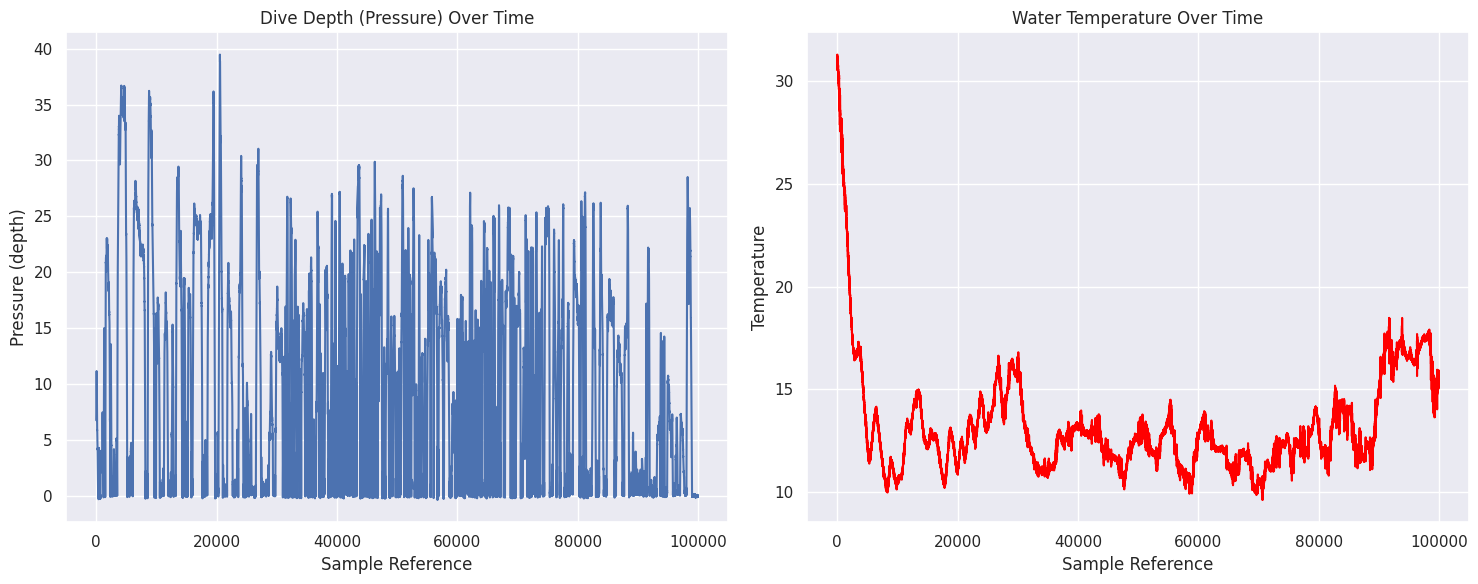

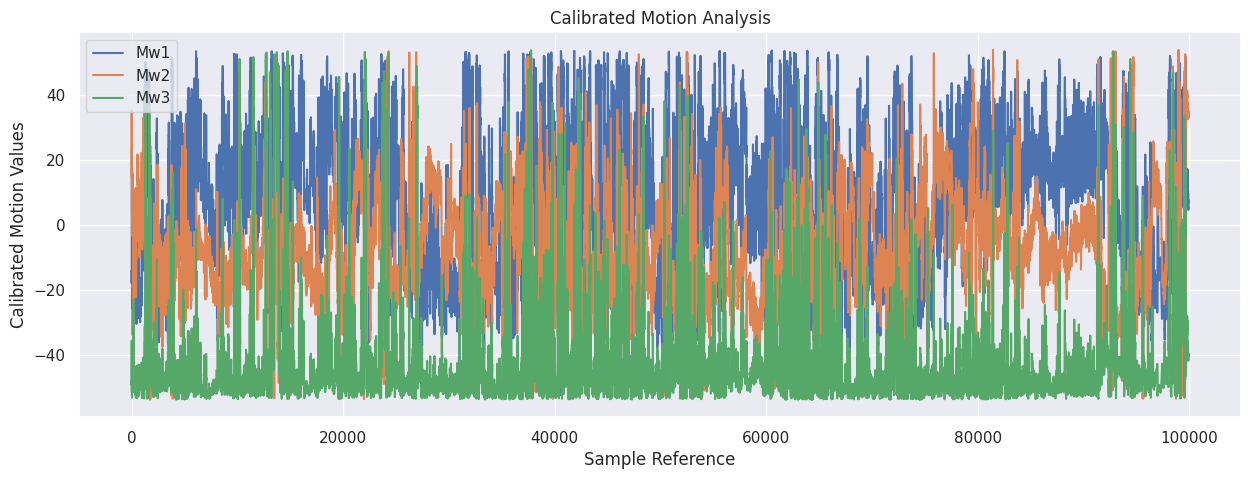

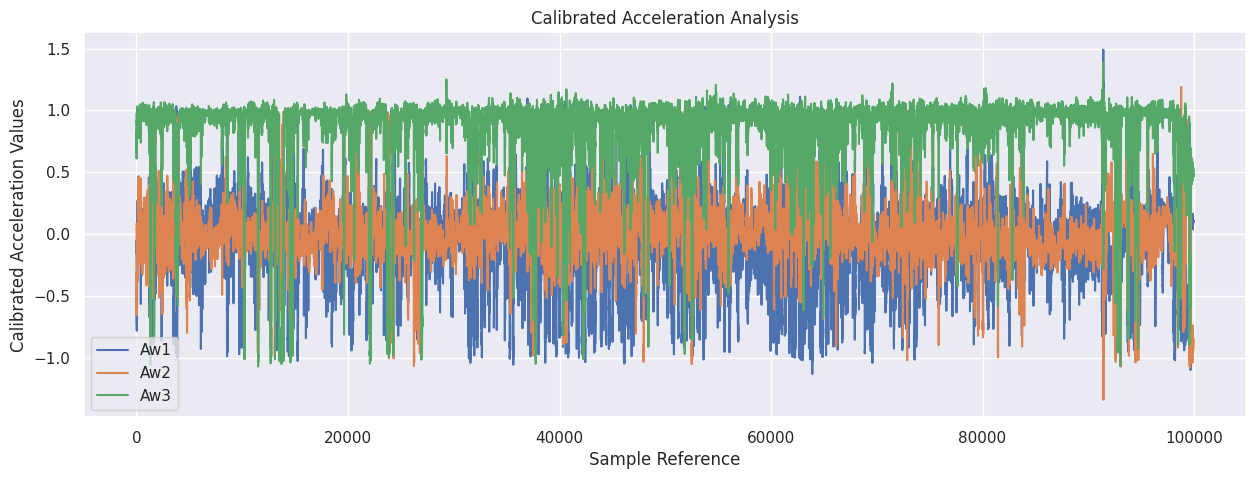


Statistical Summary of Metrics:
           pressure         tempr           Mw1           Mw2           Mw3  \
count  99925.000000  99925.000000  99925.000000  99925.000000  99925.000000   
mean      10.609066     13.228823      6.763895     -7.790611    -41.607433   
std        9.088614      2.609002     21.882983     17.005742     16.116647   
min       -0.352956      9.622080    -52.996400    -53.741300    -53.721100   
25%        1.782620     11.737000    -10.499400    -19.349700    -50.072200   
50%        9.425150     12.607800      9.087600     -8.820800    -47.092200   
75%       17.331300     13.811900     22.381600      3.110300    -40.490800   
max       39.462700     31.301000     53.713100     53.950400     53.778500   

                Aw1           Aw2           Aw3         pitch          roll  \
count  99925.000000  99925.000000  99925.000000  99925.000000  99925.000000   
mean      -0.041197      0.025734      0.850842     -0.047989      0.033356   
std        0.35084

In [7]:
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

def visualize_whale_data():
    try:
        # Connect to database
        conn = mysql.connector.connect(
            host="localhost",
            user=os.environ.get('MYSQL_TEST_USER'),
            password=os.environ.get('MYSQL_TEST_PASSWORD'),
            database="WDAS_TEST"
        )
        cursor = conn.cursor(dictionary=True)

        # 1. Get the basic dataset info
        cursor.execute("""
        SELECT dataset_id, dataset_name
        FROM DATASET_DETAILS
        ORDER BY dataset_id DESC LIMIT 1
        """)
        dataset_info = cursor.fetchone()
        dataset_id = int(dataset_info['dataset_id'])  # Convert to regular int

        # 2. Get the main data
        cursor.execute("""
        SELECT sample_ref, pressure, tempr,
               Mw1, Mw2, Mw3, Aw1, Aw2, Aw3,
               pitch, roll, head
        FROM DATASETS
        WHERE dataset_id = %s
        ORDER BY sample_ref
        """, (dataset_id,))

        # Convert to pandas DataFrame
        data = cursor.fetchall()
        df = pd.DataFrame(data)

        # 3. Get annotations
        cursor.execute("""
        SELECT start_sample, end_sample, class, subclass
        FROM ANNOTATIONS
        WHERE dataset_id = %s
        """, (dataset_id,))

        annotations_data = cursor.fetchall()
        annotations_df = pd.DataFrame(annotations_data)

        # Print data info before plotting
        print("Dataset shape:", df.shape)
        print("\nDataset columns:", df.columns.tolist())
        print("\nFirst few rows of data:")
        print(df.head())

        print("\nAnnotations shape:", annotations_df.shape)
        if not annotations_df.empty:
            print("\nFirst few annotations:")
            print(annotations_df.head())

        # Create visualizations
        sns.set_style("whitegrid")
        sns.set_theme(style="darkgrid")

        # 1. Pressure and Temperature Over Time
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.plot(df['sample_ref'], df['pressure'], label='Pressure')
        plt.title('Dive Depth (Pressure) Over Time')
        plt.xlabel('Sample Reference')
        plt.ylabel('Pressure (depth)')

        plt.subplot(1, 2, 2)
        plt.plot(df['sample_ref'], df['tempr'], label='Temperature', color='red')
        plt.title('Water Temperature Over Time')
        plt.xlabel('Sample Reference')
        plt.ylabel('Temperature')
        plt.tight_layout()
        plt.show()

        # 2. Calibrated Motion Analysis (Mw1, Mw2, Mw3)
        plt.figure(figsize=(15, 5))
        plt.plot(df['sample_ref'], df['Mw1'], label='Mw1')
        plt.plot(df['sample_ref'], df['Mw2'], label='Mw2')
        plt.plot(df['sample_ref'], df['Mw3'], label='Mw3')
        plt.title('Calibrated Motion Analysis')
        plt.xlabel('Sample Reference')
        plt.ylabel('Calibrated Motion Values')
        plt.legend()
        plt.show()

        # 3. Calibrated Acceleration Analysis (Aw1, Aw2, Aw3)
        plt.figure(figsize=(15, 5))
        plt.plot(df['sample_ref'], df['Aw1'], label='Aw1')
        plt.plot(df['sample_ref'], df['Aw2'], label='Aw2')
        plt.plot(df['sample_ref'], df['Aw3'], label='Aw3')
        plt.title('Calibrated Acceleration Analysis')
        plt.xlabel('Sample Reference')
        plt.ylabel('Calibrated Acceleration Values')
        plt.legend()
        plt.show()

        if not annotations_df.empty:
            # 4. Combined Visualization with Annotations
            plt.figure(figsize=(15, 10))

            # Create subplots
            ax1 = plt.subplot(311)  # Pressure
            ax2 = plt.subplot(312)  # Motion
            ax3 = plt.subplot(313)  # Acceleration

            # Plot pressure with annotations
            ax1.plot(df['sample_ref'], df['pressure'], label='Pressure', alpha=0.7)
            ax1.set_title('Dive Profile with Annotations')
            ax1.set_ylabel('Pressure (depth)')

            # Plot calibrated motion
            ax2.plot(df['sample_ref'], df['Mw1'], label='Mw1')
            ax2.plot(df['sample_ref'], df['Mw2'], label='Mw2')
            ax2.plot(df['sample_ref'], df['Mw3'], label='Mw3')
            ax2.set_title('Calibrated Motion')
            ax2.set_ylabel('Motion Values')
            ax2.legend()

            # Plot calibrated acceleration
            ax3.plot(df['sample_ref'], df['Aw1'], label='Aw1')
            ax3.plot(df['sample_ref'], df['Aw2'], label='Aw2')
            ax3.plot(df['sample_ref'], df['Aw3'], label='Aw3')
            ax3.set_title('Calibrated Acceleration')
            ax3.set_ylabel('Acceleration Values')
            ax3.set_xlabel('Sample Reference')
            ax3.legend()

            # Add annotations to all subplots
            colors = plt.cm.rainbow(np.linspace(0, 1, len(annotations_df)))
            for idx, annotation in annotations_df.iterrows():
                start = int(annotation['start_sample'])
                end = int(annotation['end_sample'])
                label = f"{annotation['class']} - {annotation['subclass']}"
                alpha = 0.2

                for ax in [ax1, ax2, ax3]:
                    ax.axvspan(start, end, alpha=alpha, color=colors[idx],
                              label=f'Annotation: {label}')

            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

        # 5. Statistical Summary
        print("\nStatistical Summary of Metrics:")
        metrics = ['pressure', 'tempr', 'Mw1', 'Mw2', 'Mw3', 'Aw1', 'Aw2', 'Aw3', 'pitch', 'roll', 'head']
        print(df[metrics].describe())

        # 6. Annotation Summary
        if not annotations_df.empty:
            print("\nAnnotation Summary:")
            print(f"Total number of annotations: {len(annotations_df)}")

            print("\nClass distribution:")
            print(annotations_df['class'].value_counts())

            print("\nAnnotation duration statistics:")
            annotations_df['duration'] = annotations_df['end_sample'].astype(int) - annotations_df['start_sample'].astype(int)
            print(f"Mean duration: {annotations_df['duration'].mean():.2f} samples")
            print(f"Max duration: {annotations_df['duration'].max()} samples")
            print(f"Min duration: {annotations_df['duration'].min()} samples")

    except Exception as e:
        print(f"Error during visualization: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Run the visualization
visualize_whale_data()


#6. Import and Visualize Annotations



In [8]:
import mysql.connector
import pandas as pd
import requests
import io
import os
from datetime import datetime

def download_github_file(url):
    """Download raw content from GitHub."""
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    print(f"Downloading from: {raw_url}")

    response = requests.get(raw_url)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    else:
        raise Exception(f"Failed to download file: {response.status_code}")

def clean_column_names(df):
    """Clean column names to match database schema."""
    df.columns = df.columns.str.replace('.', '')
    return df

def import_annotations_with_whales(conn_params):
    """Import annotations and handle whale information with class-subclass mapping."""
    try:
        conn = mysql.connector.connect(**conn_params)
        cursor = conn.cursor(dictionary=True)

        # Get the latest dataset_id first
        cursor.execute("""
            SELECT dataset_id FROM DATASET_DETAILS
            ORDER BY dataset_id DESC LIMIT 1
        """)
        result = cursor.fetchone()
        if not result:
            raise Exception("No datasets found in the database")
        dataset_id = result['dataset_id']
        print(f"Using dataset_id: {dataset_id}")

        # Download and clean the annotations data
        annotations_url = "https://github.com/GilRaitses/minML/blob/main/annotations/annotations.csv"
        annotations_df = download_github_file(annotations_url)
        annotations_df = clean_column_names(annotations_df)

        print("Downloaded annotations columns:", annotations_df.columns.tolist())
        print("First few rows:", annotations_df.head())

        # First, process the distinct class-subclass pairs from the data
        # Using 'state' and 'event' columns to create class-subclass pairs
        class_subclass_pairs = set()
        for _, row in annotations_df.iterrows():
            class_subclass_pairs.add((row['state'], row['event']))

        # Insert class-subclass mappings
        for main_class, subclass in class_subclass_pairs:
            try:
                cursor.execute("""
                    INSERT IGNORE INTO CLASS_SUBCLASS_MAP (class, subclass)
                    VALUES (%s, %s)
                """, (main_class, subclass))
            except Exception as e:
                print(f"Warning: Could not insert class-subclass mapping {main_class}-{subclass}: {e}")

        conn.commit()

        # Process each annotation
        annotations_processed = 0
        for _, row in annotations_df.iterrows():
            try:
                # Handle whale information using whaleID and whaleName
                whale_id = row['whaleID']
                whale_name = row['whaleName']

                # Insert whale and get ID
                cursor.execute("""
                    INSERT IGNORE INTO WHALES (tag_id, species, sex)
                    VALUES (%s, %s, %s)
                """, (whale_id, "Unknown", "Unknown"))

                cursor.execute("SELECT whale_id FROM WHALES WHERE tag_id = %s", (whale_id,))
                whale_record = cursor.fetchone()
                whale_id = whale_record["whale_id"]

                # Insert the annotation
                cursor.execute("""
                    INSERT INTO ANNOTATIONS
                    (dataset_id, whale_id, start_sample, end_sample,
                     class, subclass, confidence_score)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                """, (
                    dataset_id,
                    whale_id,
                    row['eventStart'],
                    row['eventEnd'],
                    row['state'],      # Using state as class
                    row['event'],      # Using event as subclass
                    1.0                # Default confidence score
                ))

                annotations_processed += 1
                if annotations_processed % 100 == 0:
                    conn.commit()
                    print(f"Processed {annotations_processed} annotations")

            except Exception as e:
                print(f"Error processing annotation {annotations_processed}: {e}")
                continue

        # Final commit
        conn.commit()

        # Log the import
        cursor.execute("""
            INSERT INTO IMPORT_LOGS (file_path, dataset_id, import_time)
            VALUES (%s, %s, NOW())
        """, (annotations_url, dataset_id))

        conn.commit()
        print(f"Import complete! Processed {annotations_processed} annotations successfully!")

    except Exception as e:
        print(f"Error during annotation import: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Example usage
if __name__ == "__main__":
    conn_params = {
        "host": "localhost",
        "user": os.environ.get('MYSQL_TEST_USER'),
        "password": os.environ.get('MYSQL_TEST_PASSWORD'),
        "database": "WDAS_TEST"
    }

    import_annotations_with_whales(conn_params)

Using dataset_id: 1
Downloaded annotations columns: ['whaleID', 'whaleName', 'sampleHz', 'eventStart', 'eventEnd', 'state', 'event']
First few rows:      whaleID       whaleName  sampleHz  eventStart  eventEnd    state  \
0  mn09_203a  lavaliers_Calf         5         131       530  Feeding   
1  mn09_203a  lavaliers_Calf         5         531      1130  Feeding   
2  mn09_203a  lavaliers_Calf         5        1135      1975  Feeding   
3  mn09_203a  lavaliers_Calf         5        1976      2860  Feeding   
4  mn09_203a  lavaliers_Calf         5        2105      2390  Feeding   

               event  
0         Side rolls  
1         Side rolls  
2  Exploratory dives  
3         Side rolls  
4         Side rolls  
Import complete! Processed 51 annotations successfully!



Available Annotations:
ID: 1, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 79.8s
ID: 2, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 119.8s
ID: 3, Whale: mn09_203a, Type: Feeding-Exploratory dives, Duration: 168.0s
ID: 4, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 176.8s
ID: 5, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 57.0s
ID: 6, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 35.8s
ID: 7, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 105.8s
ID: 8, Whale: mn09_203a, Type: Feeding-Exploratory dives, Duration: 114.0s
ID: 9, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 58.4s
ID: 10, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 53.8s
ID: 11, Whale: mn09_203a, Type: Feeding-Side rolls and loop, Duration: 72.0s
ID: 12, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 59.8s
ID: 13, Whale: mn09_203a, Type: Feeding-Feeding loop, Duration: 61.8s
ID: 14, Whale: mn09_203a, Type: Feeding-Side rolls, Duration: 54.8s
ID:

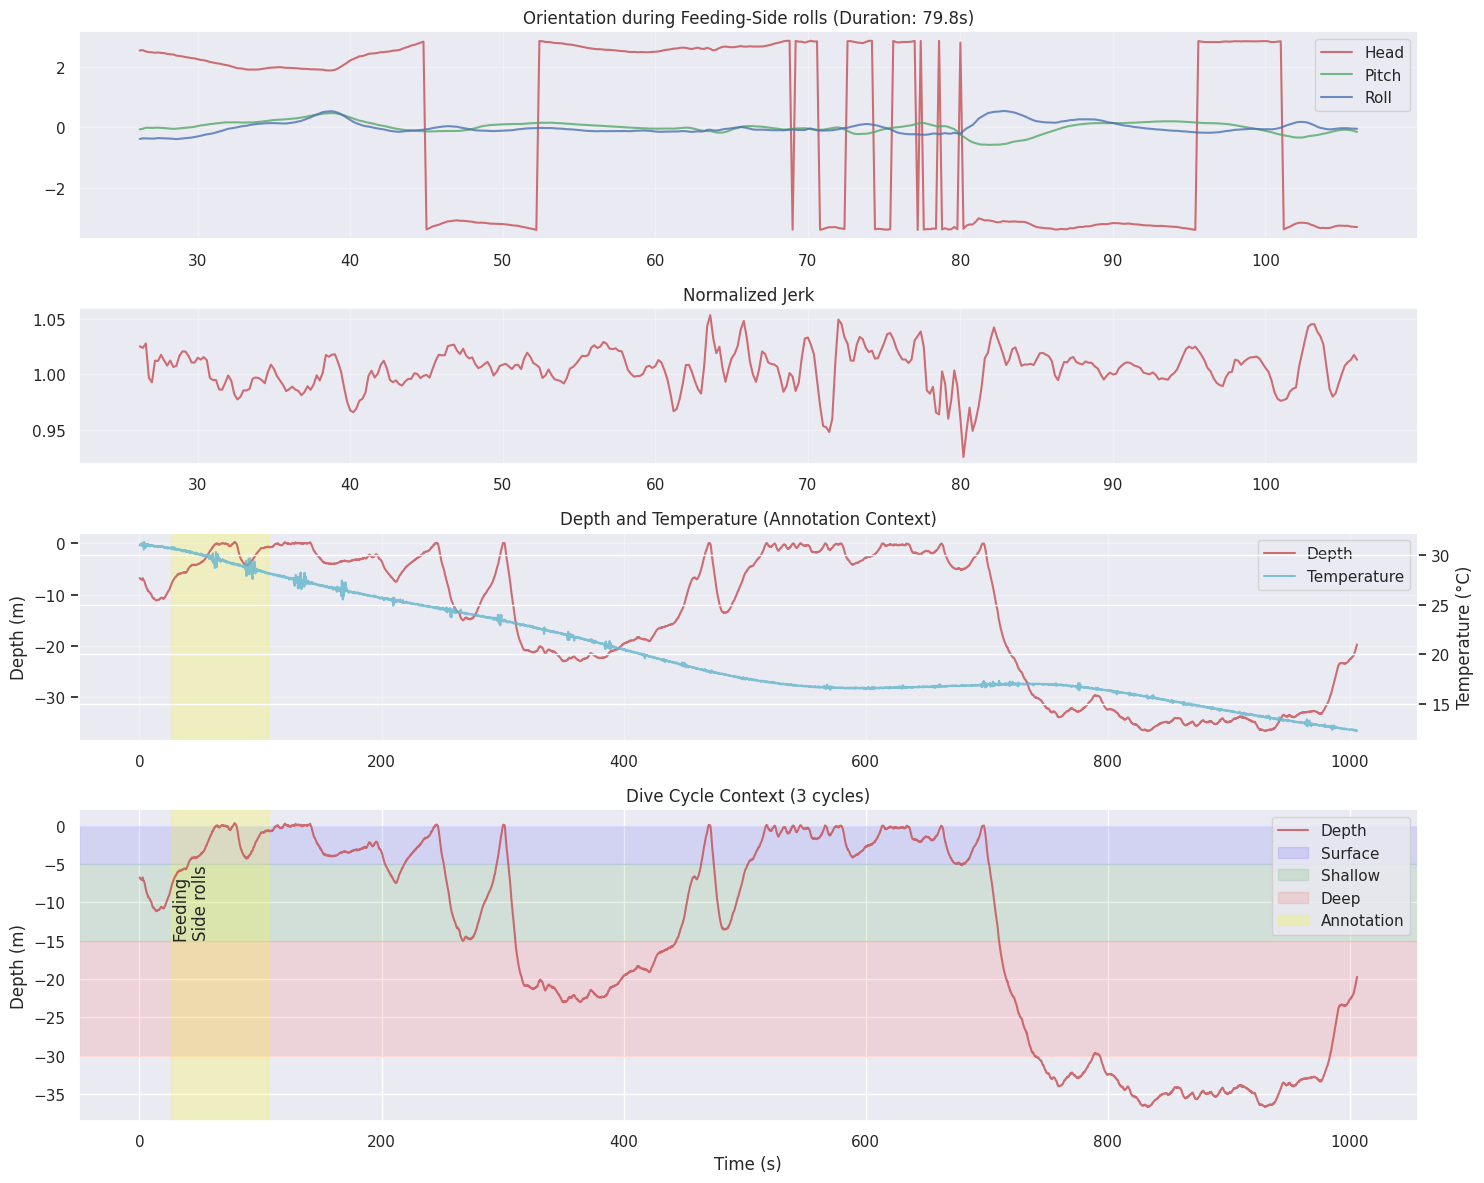


Annotation Details:
Whale: mn09_203a
Class: Feeding
Subclass: Side rolls
Duration: 79.8 seconds
Confidence Score: 1.00


In [9]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

def get_dive_cycles(df, surface_threshold=-5):
    """Identify dive cycles from depth data."""
    surface_periods = df['depth'] > surface_threshold
    dive_starts = []
    dive_ends = []

    # Find dive start/end points
    in_dive = False
    for i in range(1, len(df)):
        if not in_dive and df['depth'].iloc[i] < surface_threshold:
            dive_starts.append(i)
            in_dive = True
        elif in_dive and df['depth'].iloc[i] > surface_threshold:
            dive_ends.append(i)
            in_dive = False

    # Pair starts and ends
    return list(zip(dive_starts, dive_ends))

def visualize_annotation_detail(conn_params, annotation_id=1):
    """Create detailed visualization for a single annotation with dive cycle context."""
    try:
        conn = mysql.connector.connect(**conn_params)
        cursor = conn.cursor(dictionary=True)

        # Get annotation details
        cursor.execute("""
            SELECT
                a.*,
                d.dataset_name,
                w.tag_id as whale_tag,
                MIN(ds.sample_ref) as min_sample,
                MAX(ds.sample_ref) as max_sample
            FROM ANNOTATIONS a
            JOIN DATASET_DETAILS d ON a.dataset_id = d.dataset_id
            JOIN WHALES w ON a.whale_id = w.whale_id
            JOIN DATASETS ds ON a.dataset_id = ds.dataset_id
            WHERE a.annotation_id = %s
            GROUP BY a.annotation_id, d.dataset_name, w.tag_id
        """, (annotation_id,))
        annotation = cursor.fetchone()

        if not annotation:
            print(f"No annotation found with ID {annotation_id}")
            return

        # Calculate window for 3 dive cycles
        avg_dive_duration = 300  # Initial estimate: 5 minutes in seconds
        context_window = avg_dive_duration * 3  # Three dive cycles
        padding = int(context_window * 5)  # Convert to samples (5Hz)

        # Get data window
        start_sample = max(annotation['min_sample'], annotation['start_sample'] - padding)
        end_sample = min(annotation['max_sample'], annotation['end_sample'] + padding)

        cursor.execute("""
            SELECT
                sample_ref/5.0 as time,
                pressure as depth,
                tempr,
                pitch,
                roll,
                head,
                SQRT(POW(Aw1, 2) + POW(Aw2, 2) + POW(Aw3, 2)) as norm_jerk
            FROM DATASETS
            WHERE dataset_id = %s
                AND sample_ref BETWEEN %s AND %s
            ORDER BY sample_ref
        """, (annotation['dataset_id'], start_sample, end_sample))

        df = pd.DataFrame(cursor.fetchall())

        if df.empty:
            print("No data found for this annotation period")
            return

        # Find dive cycles
        dive_cycles = get_dive_cycles(df)

        # Adjust window to show 3 complete dive cycles
        if len(dive_cycles) >= 3:
            cycle_start = max(0, len(dive_cycles) // 2 - 1)  # Center on the dive containing annotation
            relevant_cycles = dive_cycles[cycle_start:cycle_start + 3]
            df_window = df.iloc[relevant_cycles[0][0]:relevant_cycles[-1][1]]
        else:
            df_window = df

        # Create figure
        fig = plt.figure(figsize=(15, 12))
        gs = GridSpec(4, 1, height_ratios=[1, 0.75, 1, 1.5])

        # 1. Pitch, Roll, Head plot (annotation window only)
        ax1 = fig.add_subplot(gs[0])
        annotation_df = df[
            (df['time'] >= annotation['start_sample']/5.0) &
            (df['time'] <= annotation['end_sample']/5.0)
        ]
        ax1.plot(annotation_df['time'], annotation_df['head'], 'r-', label='Head', alpha=0.8)
        ax1.plot(annotation_df['time'], annotation_df['pitch'], 'g-', label='Pitch', alpha=0.8)
        ax1.plot(annotation_df['time'], annotation_df['roll'], 'b-', label='Roll', alpha=0.8)
        ax1.set_title(f"Orientation during {annotation['class']}-{annotation['subclass']} "
                    f"(Duration: {(annotation['end_sample']-annotation['start_sample'])/5:.1f}s)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Normalized Jerk plot (annotation window only)
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(annotation_df['time'], annotation_df['norm_jerk'], 'r-', label='Norm Jerk', alpha=0.8)
        ax2.set_title('Normalized Jerk')
        ax2.grid(True, alpha=0.3)

        # 3. Depth and Temperature (annotation window with padding)
        ax3 = fig.add_subplot(gs[2])
        ax3_twin = ax3.twinx()

        ax3.plot(df['time'], -df['depth'], 'r-', label='Depth', alpha=0.8)
        ax3_twin.plot(df['time'], df['tempr'], 'c-', label='Temperature', alpha=0.8)

        # Highlight annotation period
        annotation_start = annotation['start_sample'] / 5.0
        annotation_end = annotation['end_sample'] / 5.0
        ax3.axvspan(annotation_start, annotation_end, color='yellow', alpha=0.2)

        ax3.set_ylabel('Depth (m)')
        ax3_twin.set_ylabel('Temperature (°C)')
        ax3.set_title('Depth and Temperature (Annotation Context)')

        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2)
        ax3.grid(True, alpha=0.3)

        # 4. Dive Cycle Context
        ax4 = fig.add_subplot(gs[3])
        ax4.plot(df_window['time'], -df_window['depth'], 'r-', label='Depth', alpha=0.8)

        # Add phase regions
        surface_level = -5
        shallow_level = -15
        deep_level = -30

        ax4.axhspan(0, surface_level, alpha=0.1, color='blue', label='Surface')
        ax4.axhspan(surface_level, shallow_level, alpha=0.1, color='green', label='Shallow')
        ax4.axhspan(shallow_level, deep_level, alpha=0.1, color='red', label='Deep')

        # Highlight annotation period
        if (df_window['time'].min() <= annotation_start <= df_window['time'].max()):
            ax4.axvspan(annotation_start, annotation_end,
                    alpha=0.2, color='yellow', label='Annotation')
            # Add annotation label
            ax4.text(annotation_start, surface_level,
                    f"{annotation['class']}\n{annotation['subclass']}",
                    rotation=90, verticalalignment='top')

        ax4.set_title('Dive Cycle Context (3 cycles)')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Depth (m)')
        ax4.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

        # Print annotation details
        print(f"\nAnnotation Details:")
        print(f"Whale: {annotation['whale_tag']}")
        print(f"Class: {annotation['class']}")
        print(f"Subclass: {annotation['subclass']}")
        print(f"Duration: {(annotation['end_sample'] - annotation['start_sample'])/5:.1f} seconds")
        if annotation['confidence_score']:
            print(f"Confidence Score: {annotation['confidence_score']:.2f}")

    except Exception as e:
        print(f"Error during visualization: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

def list_annotations(conn_params):
    """List available annotations with updated schema fields."""
    conn = mysql.connector.connect(**conn_params)
    cursor = conn.cursor(dictionary=True)
    cursor.execute("""
        SELECT
            a.annotation_id,
            a.class,
            a.subclass,
            a.start_sample,
            a.end_sample,
            w.tag_id as whale_tag
        FROM ANNOTATIONS a
        JOIN WHALES w ON a.whale_id = w.whale_id
        ORDER BY a.annotation_id
    """)
    annotations = cursor.fetchall()
    print("\nAvailable Annotations:")
    for ann in annotations:
        print(f"ID: {ann['annotation_id']}, Whale: {ann['whale_tag']}, "
              f"Type: {ann['class']}-{ann['subclass']}, "
              f"Duration: {(ann['end_sample'] - ann['start_sample'])/5:.1f}s")
    cursor.close()
    conn.close()

# Example usage
if __name__ == "__main__":
    conn_params = {
        "host": "localhost",
        "user": os.environ.get('MYSQL_TEST_USER'),
        "password": os.environ.get('MYSQL_TEST_PASSWORD'),
        "database": "WDAS_TEST"
    }

    list_annotations(conn_params)
    visualize_annotation_detail(conn_params, annotation_id=1)  # Adjust ID as needed

#7. ML Classification

In [23]:
def setup_dependencies():
    """Install required packages only if they're not already present."""
    import pkg_resources
    import subprocess
    import sys

    required_packages = {
        'torch': 'torch',
        'numpy': 'numpy',
        'pandas': 'pandas',
        'scikit-learn': 'sklearn',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
        'psutil': 'psutil',
        'mysql-connector-python': 'mysql.connector'
    }

    installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

    for package, import_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"✓ {package} is already installed")
        except ImportError:
            print(f"Installing {package}...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package])
                print(f"✓ Successfully installed {package}")
            except subprocess.CalledProcessError as e:
                print(f"✗ Failed to install {package}: {str(e)}")
                raise

    print("\nAll required packages are ready!")

# Run the setup
if __name__ == "__main__":
    setup_dependencies()

<ipython-input-23-41af34aba2c1>:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


✓ torch is already installed
✓ numpy is already installed
✓ pandas is already installed
✓ scikit-learn is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
✓ psutil is already installed
✓ mysql-connector-python is already installed

All required packages are ready!


In [24]:
# 2: Configuration and Dataset Classes
@dataclass
class ModelConfig:
    """Configuration for model training and evaluation."""
    window_size: int = 25
    stride: int = 12
    hidden_size: int = 64
    num_layers: int = 2
    dropout: float = 0.3
    batch_size: int = 32
    learning_rate: float = 0.001
    num_epochs: int = 50
    use_pca: bool = False
    pca_components: int = 50

class WhaleDataset(Dataset):
    """Dataset for windowed whale behavior data."""
    def __init__(self, features: np.ndarray, labels: np.ndarray):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [25]:
# 3: Model Architectures
class MinGRUCell(nn.Module):
    """Minimal GRU cell implementation."""
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wz = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wr = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wh = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        combined = torch.cat((x, h), dim=1)
        z = torch.sigmoid(self.Wz(combined))
        r = torch.sigmoid(self.Wr(combined))
        h_tilde = torch.tanh(self.Wh(torch.cat((x, r * h), dim=1)))
        h_next = (1 - z) * h + z * h_tilde
        return h_next

class MinGRU(nn.Module):
    """Minimal GRU model for whale behavior classification."""
    def __init__(self, input_size: int, hidden_size: int, num_classes: int,
                 num_layers: int = 2, dropout: float = 0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru_cells = nn.ModuleList([
            MinGRUCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size).to(x.device)
             for _ in range(self.num_layers)]

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if layer == 0:
                    h[layer] = self.gru_cells[layer](x_t, h[layer])
                else:
                    h[layer] = self.gru_cells[layer](
                        self.dropout(h[layer-1]), h[layer]
                    )

        out = self.fc(self.dropout(h[-1]))
        return out

class TraditionalGRU(nn.Module):
    """Traditional GRU model for comparison."""
    def __init__(self, input_size: int, hidden_size: int, num_classes: int,
                 num_layers: int = 2, dropout: float = 0.3):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, h_n = self.gru(x)
        out = self.fc(self.dropout(h_n[-1]))
        return out

In [26]:
# 4: Main Pipeline Class
class WhaleBehaviorPipeline:
    """End-to-end pipeline for whale behavior classification."""

    def __init__(self, config: ModelConfig, conn_params: Dict):
        self.config = config
        self.conn_params = conn_params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        """Prepare windowed data from database."""
        print("Loading data from database...")
        conn = mysql.connector.connect(**self.conn_params)
        cursor = conn.cursor(dictionary=True)

        try:
            # Get latest dataset
            cursor.execute("""
                SELECT dataset_id
                FROM DATASET_DETAILS
                ORDER BY dataset_id DESC
                LIMIT 1
            """)
            dataset_id = cursor.fetchone()['dataset_id']

            # Get data with annotations
            cursor.execute("""
                SELECT
                    d.*,
                    COALESCE(a.class, 'Unknown') as behavior_class
                FROM DATASETS d
                LEFT JOIN ANNOTATIONS a
                    ON d.dataset_id = a.dataset_id
                    AND d.sample_ref BETWEEN a.start_sample AND a.end_sample
                WHERE d.dataset_id = %s
                ORDER BY d.sample_ref
            """, (dataset_id,))

            data = pd.DataFrame(cursor.fetchall())

            # Get classes
            cursor.execute("""
                SELECT DISTINCT class
                FROM ANNOTATIONS
                WHERE dataset_id = %s
            """, (dataset_id,))
            classes = [row['class'] for row in cursor.fetchall()]
            class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

            # Prepare features
            feature_cols = [
                'pressure', 'tempr', 'M1', 'M2', 'M3',
                'A1', 'A2', 'A3', 'Aw1', 'Aw2', 'Aw3',
                'Mw1', 'Mw2', 'Mw3', 'pitch', 'roll', 'head'
            ]

            # Create windows
            windows = []
            labels = []

            for i in range(0, len(data) - self.config.window_size + 1,
                          self.config.stride):
                window = data[feature_cols].iloc[i:i + self.config.window_size].values
                label = data['behavior_class'].iloc[i:i + self.config.window_size].mode()[0]

                if self.config.use_pca:
                    pca = PCA(n_components=self.config.pca_components)
                    window = pca.fit_transform(window)

                windows.append(window)
                labels.append(class_to_idx.get(label, len(classes)))

            return np.array(windows), np.array(labels), classes

        finally:
            cursor.close()
            conn.close()

    def train_evaluate_model(self, model_class: nn.Module,
                           X_train: np.ndarray, y_train: np.ndarray,
                           X_val: np.ndarray, y_val: np.ndarray,
                           fold_idx: int) -> Dict:
        """Train and evaluate a model using cross-validation."""
        model = model_class(
            input_size=X_train.shape[2],
            hidden_size=self.config.hidden_size,
            num_classes=len(np.unique(y_train)),
            num_layers=self.config.num_layers,
            dropout=self.config.dropout
        ).to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=self.config.learning_rate
        )

        # Training loop
        train_losses = []
        val_losses = []
        start_time = time.time()
        memory_usage = []

        for epoch in range(self.config.num_epochs):
            model.train()
            train_loss = 0

            for batch_idx in range(0, len(X_train), self.config.batch_size):
                batch_X = torch.FloatTensor(
                    X_train[batch_idx:batch_idx + self.config.batch_size]
                ).to(self.device)
                batch_y = torch.LongTensor(
                    y_train[batch_idx:batch_idx + self.config.batch_size]
                ).to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            val_preds = []

            with torch.no_grad():
                for batch_idx in range(0, len(X_val), self.config.batch_size):
                    batch_X = torch.FloatTensor(
                        X_val[batch_idx:batch_idx + self.config.batch_size]
                    ).to(self.device)
                    batch_y = torch.LongTensor(
                        y_val[batch_idx:batch_idx + self.config.batch_size]
                    ).to(self.device)

                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
                    val_preds.extend(outputs.argmax(dim=1).cpu().numpy())

            # Log metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            memory_usage.append(psutil.Process().memory_info().rss / 1024 / 1024)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}/{self.config.num_epochs}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Final evaluation
        model.eval()
        with torch.no_grad():
            y_pred = []
            for batch_idx in range(0, len(X_val), self.config.batch_size):
                batch_X = torch.FloatTensor(
                    X_val[batch_idx:batch_idx + self.config.batch_size]
                ).to(self.device)
                outputs = model(batch_X)
                y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred, average='weighted'),
            'precision': precision_score(y_val, y_pred, average='weighted'),
            'recall': recall_score(y_val, y_pred, average='weighted'),
            'training_time': time.time() - start_time,
            'peak_memory_mb': max(memory_usage)
        }

        return metrics

In [ ]:
# 5: Pipeline Execution
import os

if __name__ == "__main__":
    config = ModelConfig()
    conn_params = {
        "host": "localhost",
        "user": os.environ.get('MYSQL_TEST_USER'),
        "password": os.environ.get('MYSQL_TEST_PASSWORD'),
        "database": "WDAS_TEST"
    }

    pipeline = WhaleBehaviorPipeline(config, conn_params)

    # Load and prepare data
    X, y, classes = pipeline.prepare_data()
    print(f"Loaded dataset with shape: {X.shape}")

    # Define models to compare
    models = {
        'MinGRU': MinGRU,
        'TraditionalGRU': TraditionalGRU
    }

    # Run cross-validation
    results = {model_name: [] for model_name in models}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        for model_name, model_class in models.items():
            print(f"\nTraining {model_name} - Fold {fold_idx + 1}/5")
            metrics = pipeline.train_evaluate_model(
                model_class, X_train, y_train, X_val, y_val, fold_idx
            )
            results[model_name].append(metrics)
            print(f"Results for {model_name}:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

    # Print final summary
    print("\nFinal Results Summary:")
    for model_name, model_results in results.items():
        print(f"\n{model_name}:")
        for metric in ['accuracy', 'f1', 'precision', 'recall', 'training_time', 'peak_memory_mb']:
            values = [r[metric] for r in model_results]
            print(f"{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")

Loading data from database...
